# GP Applied to the Even-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP. 

In [ ]:
!pip install deap

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_96700/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [2]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [3]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [4]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [5]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [6]:
NUM_INPUTS = 3
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [7]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [8]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)
primitiveSet.addPrimitive(operator.xor, 2)
primitiveSet.addPrimitive(operator.not_, 1)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [9]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



Set up our population as before

In [10]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [11]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size. 

In [12]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	3.9865	0  	8  	0  	2000  	0.760472	22.588	0  	60 	4  	2000  	13.2948
1  	1799  	3.8385	1  	8  	0  	1799  	0.753935	22.037	1  	69 	1  	1799  	13.1755
2  	1787  	3.758 	2  	8  	0  	1787  	0.802768	22.768	2  	81 	1  	1787  	13.8175
3  	1809  	3.7015	3  	8  	0  	1809  	0.867985	23.6285	3  	83 	1  	1809  	14.7388
4  	1816  	3.6695	4  	8  	0  	1816  	0.874797	25.051 	4  	86 	1  	1816  	15.4465
5  	1764  	3.568 	5  	8  	0  	1764  	0.972304	27.555 	5  	100	1  	1764  	16.6093
6  	1792  	3.4435	6  	8  	0  	1792  	1.05821 	30.569 	6  	100	1  	1792  	18.1468
7  	1810  	3.258 	7  	8  	0  	1810  	1.10247 	33.37  	7  	108	1  	1810  	18.9958
8  	1807  	3.157 	8  	8  	0  	1807  	1.16934 	36.724 	8  	1

197	1776  	3.3075 	197	64 	0  	1776  	9.28838 	182.496	197	384	16 	1776  	62.2483
198	1781  	3.322  	198	64 	0  	1781  	9.35614 	183.927	198	371	22 	1781  	64.0354
199	1808  	3.2725 	199	64 	0  	1808  	9.2643  	183.779	199	424	6  	1808  	64.598 
200	1822  	3.1045 	200	64 	0  	1822  	9.30073 	183.844	200	424	15 	1822  	64.0991


Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  xor(not_(and_(or_(in_0, in_2), and_(in_0, in_0))), or_(and_(and_(in_1, in_2), xor(0, 1)), xor(xor(in_0, or_(in_2, in_1)), not_(in_0))))
-- length=25, height=5
-- Best Fitness =  0.0


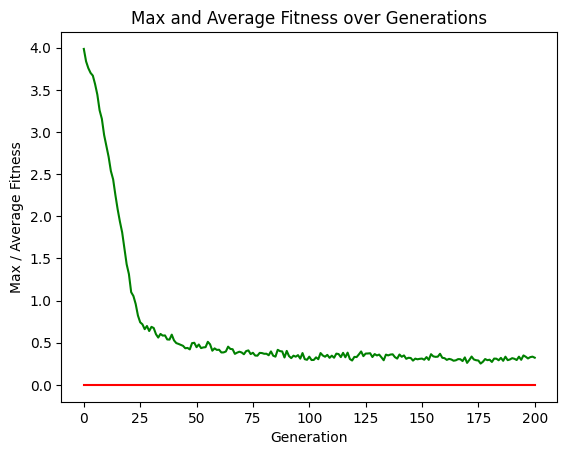

In [13]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Now, this looks way more interesting than the Symbolic Regression graph as GP is really being made to work hard here!